In [31]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import copy
from tqdm.auto import tqdm
import random
import operator
import pandas as pd
import gym

import torch

%matplotlib inline

## Метод Нелдера-Мида

Метод Нелдера — Мида, также известный как метод деформируемого многогранника и симплекс-метод, — метод безусловной оптимизации функции от нескольких переменных, не использующий производной (точнее — градиентов) функции, а поэтому легко применим к негладким и/или зашумлённым функциям.

Суть метода заключается в последовательном перемещении и деформировании симплекса вокруг точки экстремума.

Метод находит локальный экстремум и может «застрять» в одном из них. Если всё же требуется найти глобальный экстремум, можно пробовать выбирать другой начальный симплекс. Более развитый подход к исключению локальных экстремумов предлагается в алгоритмах, основанных на методе Монте-Карло, а также в эволюционных алгоритмах.

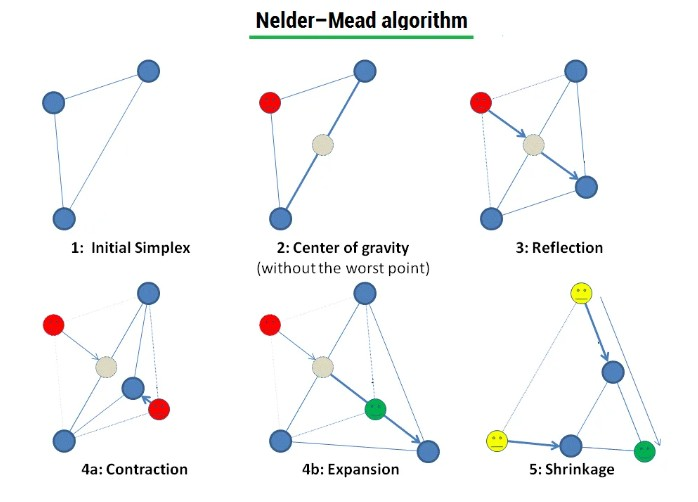

### Применение алгоритма 

```{python}
Симплекс или N-симплекс определяется как выпуклая оболочка N+1 точек,
не лежащих в одной гиперплоскости. Эти точки называются вершинами
симплекса.
Основные шаги метода:
1.Вычисление значения функции в каждой вершине симплекса.

2.Преобразование симплекса. 

В применении к данному алгоритму –отражение вершины симплекса (выбранная вершина отражается относительно
центра противоположной грани). При выборе вершины, в которой целевая
функция принимает наилучшее значение (наименьшее отрицательное
значение) алгоритм работает быстрее, но вероятность попадания в локальный
минимум возрастает. При выборе вершины, в которой целевая функция
принимает наихудшее значение (наибольшее отрицательное значение),
алгоритм работает медленнее, но надежнее.

3.Если критерий завершения удовлетворен, то поиск прекращается
```   

In [20]:
def nelder_mead(
    f,
    x_start,
    step_for_simplex = 0.1,
    no_improv_break=10,
    max_iter=0,
    alpha=1.,
    gamma=2.,
    rho=-0.5,
    sigma=0.5
) -> Tuple[np.array, float]:
    '''
    Args:
        f (Callable): function to call
        x_start (np.ndarray): array of shape (n), initial value for algo
        step_for_simplex (float): value for samplex vertices around x_start
        no_improv_break (int): break after no_improv_break iterations 
            without improvement
        max_iter (int): maximum number of iters in algo
        
        alpha (float): reflection param
        gamma (float): expansion param
        rho (float): compression param
        sigma (float): reduction param

    Returns:
        Tuple[np.array, float]: (best parameter array, best score)
    '''
    # init
    space_dim = len(x_start)
    prev_best_score = f(x_start)
    steps_with_no_improv = 0
    simplex = [[x_start, prev_best_score]]
    
    simplex_story = []
    

    # sapmle simplex
    for i in range(space_dim):
        x = x_start.copy()#copy.copy(x_start)
        x[i] = x[i] + step_for_simplex
        score = f(x)
        simplex.append([x, score])

    # simplex iter
    iters = 0

    pbar = tqdm(range(max_iter))
    for _ in pbar:
        # order
        simplex.sort(key=lambda x: x[1])
        simplex_story.append(copy.copy(simplex))
        
        best_score = simplex[0][1]

        # break after max_iter
        if iters >= max_iter:
            return (*simplex[0], simplex_story)
        iters += 1

        pbar.set_description(f'Best score: {best_score}')

        if best_score < prev_best_score:
            steps_with_no_improv = 0
            prev_best_score = best_score
        else:
            steps_with_no_improv += 1

        if steps_with_no_improv >= no_improv_break:
            return (*simplex[0], simplex_story)

        # centroid
        center_of_mass = [0.] * space_dim
        for x_vector, _ in simplex[:-1]:
            for idx, value in enumerate(x_vector):
                center_of_mass[idx] += value / (len(simplex)-1)

                
        delta_vector = center_of_mass - simplex[-1][0]
        
        # reflection
        x_reflection = center_of_mass + alpha * delta_vector
        reflection_score = f(x_reflection)
        
        if best_score <= reflection_score < simplex[-2][1]:
            # если отражение успешно - применяем его
            del simplex[-1]
            simplex.append([x_reflection, reflection_score])
            continue

        # expansion
        if reflection_score < best_score:
            x_expansion = center_of_mass + gamma * delta_vector
            expansion_score = f(x_expansion)
            if expansion_score < reflection_score:
                # если расширение удалось - применяем его
                del simplex[-1]
                simplex.append([x_expansion, expansion_score])
                continue
            else:
                # если нет - возвращаемся к удачному отражению
                del simplex[-1]
                simplex.append([x_reflection, reflection_score])
                continue

        # compression
        x_compression = center_of_mass + rho * delta_vector
        compression_score = f(x_compression)
        if compression_score < simplex[-1][1]:
            # если сжатие улучшает значение функции - применяем его
            del simplex[-1]
            simplex.append([x_compression, compression_score])
            continue

        # reduction
        best_x = simplex[0][0]
        # лучшая точка остается неизменной
        new_simplex = [simplex[0]]
        for x_vector, _ in simplex[1:]:
            # сокращение применяется ко всем точкам по направлению к лучшей
            
            x_reduction = best_x + sigma * (x_vector - best_x)
            reduction_score = f(x_reduction)
            new_simplex.append([x_reduction, reduction_score])
        simplex = new_simplex
    return simplex